# Build an autonomous multi-agents workflow to write picture book
## Part 3 Art Design - Generate Images
In this step, we will create two agents: "art designer" and "story illustrator".
The art designer generates creative art design ideas and uses a Stable Diffusion model to generate high-quality portrait images for the characters in a book.
The story illustrator breaks down each paragraph in the story into several short sentences with subject-predicate-object relationships and generates prompts.
Consolidate all artifacts including text and images and generate the story book in a docx file.
There will be two files generated in this step, one is "story.json", the other is doc file ends with ".docx". The the doc file is your final artifact. You can download it to the local computer and read it.

for [story diffusion model](https://github.com/HVision-NKU/StoryDiffusion)
- 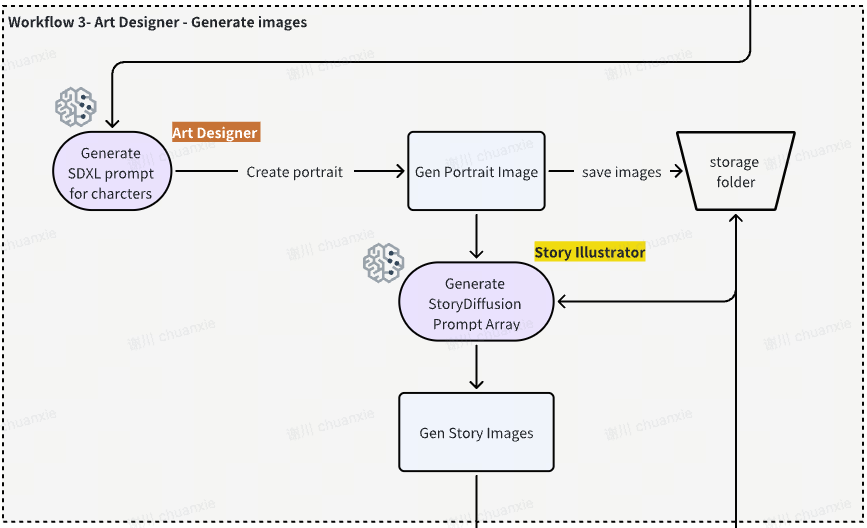

## 1. Install dependecies(if you already done in previous steps, you can skip it)

In [ ]:
%pip install -Uq langchain_community==0.2.12 langgraph==0.2.14 langchain-aws==0.1.17 langchain_core==0.2.35 python-docx==1.1.2 docx2pdf

## 2. Some Utils functions

### 2.1 Import Utils functions
- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [ ]:
from story_agents.llm_utils import CustJsonOuputParser,TextOuputParser,dict_to_obj

- we need to reconstruct the messages send to LLM strictly follow the turns ["user","assistant"]

In [ ]:
from story_agents.llm_utils import convert_message_name,reconstruct_to_claude_messages,swap_roles

### 2.2 Initiailize LLM models

In [ ]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_mistral = ChatBedrock(model_id="mistral.mistral-large-2407-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "max_tokens": 4096,
                               },
                  streaming=False,
                )

llm = llm_mistral

## 3 Agent Roles settings

- In this step, we will create two agents "art designer" and "story illustrator".
- The art designer generates creative art design ideas and use a Stable Diffusion model to generate high-quality portrait images for the characters in a book.
- The story illustrator break down the each paragraph in the story into several short sentences with subject-predicate-object relationships, and generates prompt for [story diffusion model](https://github.com/HVision-NKU/StoryDiffusion)

In [ ]:
#set background information
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""

In [ ]:
role_config = {
"art designer":
company_setting+"""You are an art designer. 
Your task is to generate creative art design ideas and use a Stable Diffusion model to generate high-quality portrait images for the characters in a book,
You need to create prompt for Stable Diffusion model with the following instructions:
<instructions>
1. Consider adding modifiers like aspect ratios, image quality settings, or post-processing instructions to refine the output.
2. Avoid topics such as pornography, racial discrimination, and toxic words.
3. Be concise and less then 30 words.
4. the prompt should always be English
5. do not output the character's name, use more general identity instead, such as a young man, an old women, a teenager boy etc.
</instructions>
Here is example:
Prompt: A highly detailed, photorealistic portrait of a young woman with long, curly red hair, fair skin, and piercing green eyes, standing in front of a window overlooking a lush forest, soft natural lighting, 4k, artstation
""",

"story illustrator":
      company_setting+ """You are a story illustrator. 
You first identify the referential relationship in the description and replace the pronouns with the names of the characters, and output your the result in <intermediate_step> tag.
Then You need to break down the description in <intermediate_step> into several short sentences with subject-predicate-object relationships, maintaining a certain logical order between the short sentences.
put your final answer in xml tag <answer>
You need to follow instructions:
<instructions>
1. Use descriptive keywords or short sentences to convey the desired content, style, action. the output should always be English.
2. If thera are characters name exists in the short sentence,  add brackets to enclose the name. for example, [Bob] invited [Alice] to join him on an adventure. 
only names which exist in <character_names> are allowed in brackets, do not add apostrophe or punctuation in it, for example [Bob's] is not allowed, it should be  [Bob]'s instead
Here is:
<character_names>
{character_names}
</character_names>

4. If there are no characters in the short sentence, add a [NC] symbol at the beginning of the sentence.For example, to generate a scene of falling leaves without any character, write: [NC] The leaves are falling.
</instructions>
Here is example:
{example}
"""
}

example = """
user input:
In the quaint mountain village of Evergreen, nestled deep within the ancient forest, lived a young boy named Liam. With an insatiable curiosity and a thirst for adventure,
On one such excursion, his keen eyes spotted a peculiar, moss-covered stone protruding from the earth in a secluded glade. 
As he brushed away the undergrowth, Liam's breath caught in his throat - for there, half-buried in the soil, lay an ornate tome bound in cracked leather and adorned with arcane symbols that seemed to pulse with an otherworldly energy.

<intermediate_step>
Liam lived in a village in the forest. Liam found a strange stone in the forest. Liam found an ancient book with arcane symbols
</intermediate_step>

<answer>
```json
{{"prompt":
    [
       "[Liam] lived in a village in the forest",
       "[Liam] found a strange stone in the forest",
       "[Liam] found an ancient book with arcane symbols"
    ]
  }}
```
</answer>
"""

## 4.Create Images based on characters persona and story

### 4.1 Import outline, characters, story created in previous notebooks

In [ ]:
from story_agents.structure_objects import Outline, Character, Story

In [ ]:
import json
# read the json file and parse to object
with open('outline.json','r') as f:
    outline_json = json.load(f)
outline = Outline.parse_obj(outline_json)

with open('characters.json','r') as f:
    characters_json = json.load(f)
characters = Character.parse_obj(characters_json)


- Input the story description file created from previous step

In [ ]:
story_filename = input()

In [ ]:

with open(story_filename,'r') as f:
    story_json = json.load(f)
story = Story.parse_obj(story_json)

In [ ]:
characters_names = characters.main_character.name+'\n'+'\n'.join([c.name for c in characters.supporting_character])
print(characters_names)

### 4.2 Initialized StoryDiffusion to generate  images
- The [StoryDiffusion model](https://github.com/HVision-NKU/StoryDiffusion) can generate character-consistent image generation over long-range sequences. It is hot-pluggable and compatible with all SD1.5 and SDXL-based image diffusion models. This model has already been deployed on AWS SageMaker while you starting the JAM event
- Find the endpoint in SageMaker console and fill the endpoint name below  
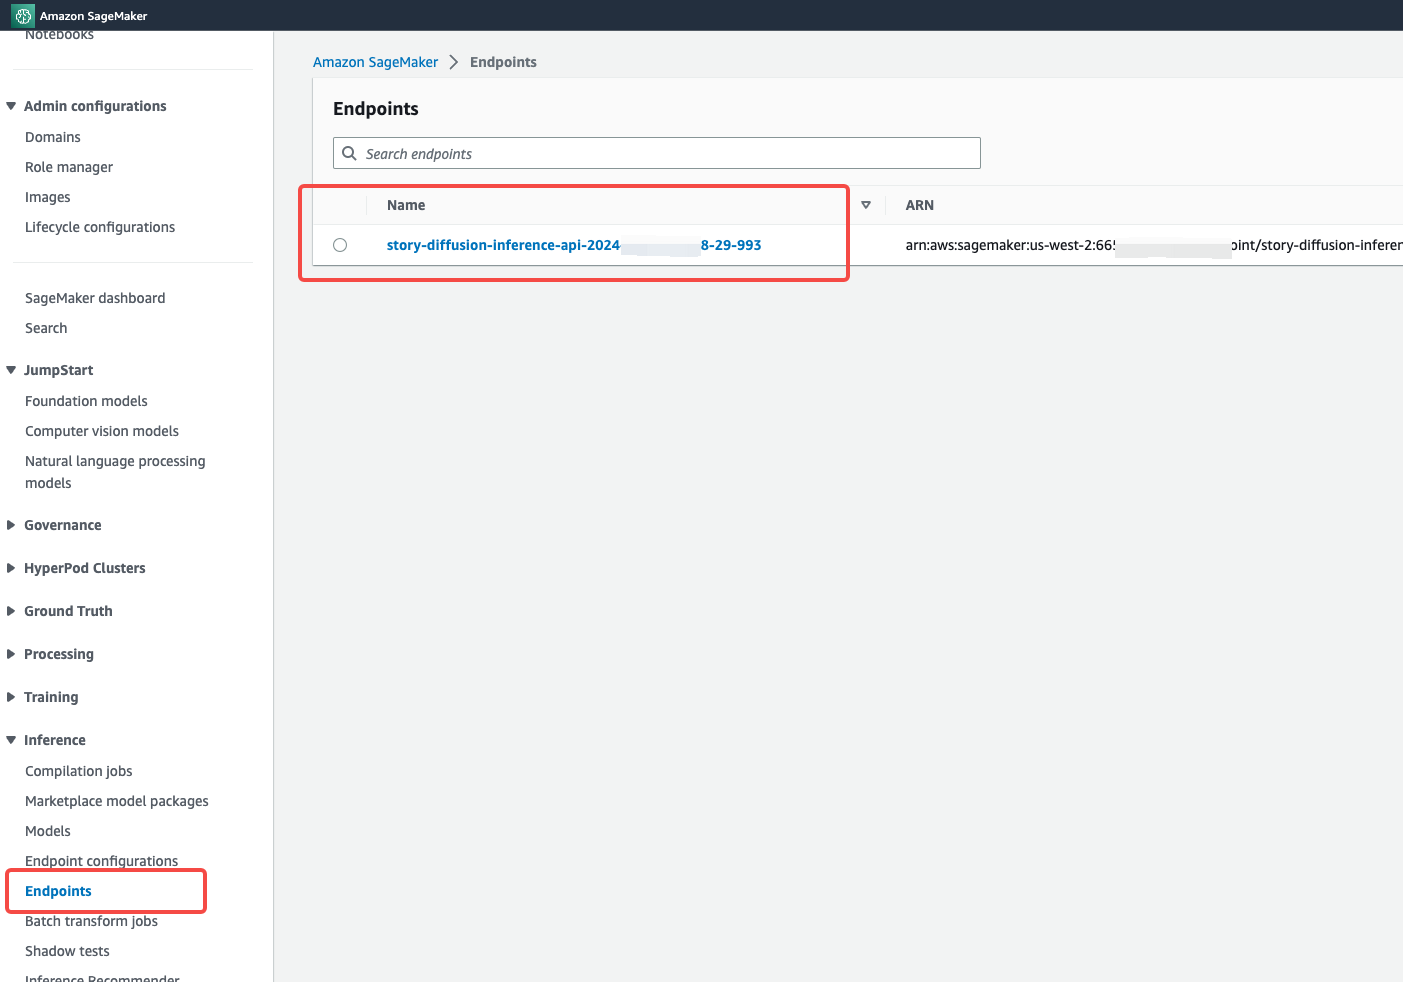

#### find the endpoint in SageMaker console and fill the endpoint name below  

In [ ]:
#find the endpoint in SageMaker console and fill the endpoint name below  
endpoint = input()

In [ ]:
from story_agents.image_utils import ImageGenerator,StoryDiffusionGenerator, save_all_images,save_all_images_names

In [ ]:
stod_image_generator = StoryDiffusionGenerator(endpoint_name=endpoint)

### 4.3 Generate identity images using StoryDiffusion model

- Define structured output for prompt output

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional,Any

class ImagePrompt(BaseModel):
    prompt: str = Field(
        description="an optimized prompt for the Stable Diffusion model based on the given instructions and guidelines, it should always be English",
    )

- Setup prompt optimzer for generating character identity images

In [ ]:
from story_agents.prompts import fc_desc
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


gen_identity_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['art designer']+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)

In [ ]:
gen_identity_chain = gen_identity_prompt | llm | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=ImagePrompt)

- test run for generation, it will create prompt for Stable diffusion model based on charcter's appearance description

In [ ]:
sd_prompt = gen_identity_chain.invoke({'messages':[HumanMessage(content= characters.main_character.figure +'\n' + characters.main_character.appearance)],'schema':ImagePrompt.schema_json()})
sd_prompt

- generate all identity images

In [ ]:
def generate_all_identities(characters,gen_identity_chain):
    batch_inputs  = [{'messages':[HumanMessage(content= characters.main_character.figure +'\n' + characters.main_character.appearance)],'schema':ImagePrompt.schema_json()}]
    figures = [characters.main_character.figure]
    character_names = [characters.main_character.name]
    for ch in characters.supporting_character:
        batch_inputs += [{'messages':[HumanMessage(content=ch.figure + '\n' + ch.appearance)],'schema':ImagePrompt.schema_json()}]
        character_names += [ch.name]
        figures += [ch.figure]
    
    sd_prompts = gen_identity_chain.batch(batch_inputs)
    images = [stod_image_generator.generate_real_identity_images(prompt=sd_prompt.prompt,general_prompt=fig) for sd_prompt,fig in zip(sd_prompts,figures)]
    # save images in folder
    imgfiles = save_all_images_names(images,character_names)
    return imgfiles,sd_prompts

In [ ]:
identity_images,sd_prompts = generate_all_identities(characters,gen_identity_chain)

### 4.4 Generate storylines prompts for story diffusion model
- To create character-consistent images, the user needs to provide at least 3 text prompts for the consistent self-attention module. so we use LLM to generate 3-5 storylines for each paragrah content.

In [ ]:
class StoryPrompt(BaseModel):
    prompt: List[str] = Field(
        # max_items=6,
        description="""an optimized prompt of lines for the StoryDiffusion model based on the given instructions and guidelines,
          it should always be English, make sure this list limits to maximum 5 items. 
         Each line in the promt should be concise and less then 10 words and maximum 5 lines are allowed for the answer""",
    )

In [ ]:
gen_image_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['story illustrator'].format(character_names=characters_names,example = example)+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)

In [ ]:
# gen_image_prompt_chain =  gen_image_prompt | llm | TextOuputParser(verbose=False)
gen_image_prompt_chain =  gen_image_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=StoryPrompt)

- generate story lines for story diffusion in parallel batch

In [ ]:

messages =  [{"messages":[HumanMessage(content=f"Here is the description:\n{chapter.content}")],'schema':StoryPrompt.schema_json()} for chapter in story.chapters] 

#### We will parse the output to structured json object, if you encounter JSONDecodeError, you can re-run it

In [ ]:
all_story_prompts = gen_image_prompt_chain.batch(messages)

In [ ]:
all_story_lines = ['\n'.join(p.prompt[:4]) for p in all_story_prompts]
all_story_lines

#### Here we use the portrait of characters as identity references for storydiffusion model

In [ ]:
from story_agents.image_utils import generate_img_dicts,prepare_storyd_prompts,save_image

- load the portrait images saved in /images folder.

In [ ]:
img_dicts = generate_img_dicts(characters)

- prepare prompts for story diffusion model. 
- Use character's portrait as reference images to keep the consistency

In [ ]:
storyd_prompts = [r for r in prepare_storyd_prompts(all_story_lines,characters,img_dicts)]

In [ ]:
len(storyd_prompts)

#### You can enter a sytle from 
- **Comic book**
- **Japanese Anime**
- **Disney Charactor**

please copy and run following cell to paste your selection



In [ ]:
sytle = input()

#### You can enter a comic type of: 
- **Four Pannel**
- **Classic Comic Style** 

please copy and run following cell to paste your selection

- Four Pannel Example: It describes a comic strip format with four equal-sized panels arranged vertically.  
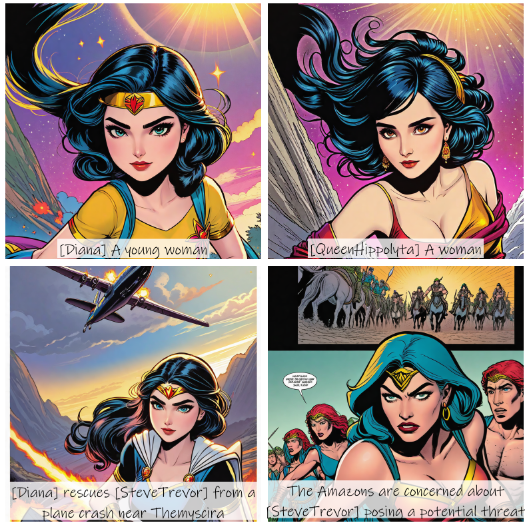

 - Classic Comic Style Example：It describes a classic comic book page layout that uses a mix of larger and smaller panels or images.  
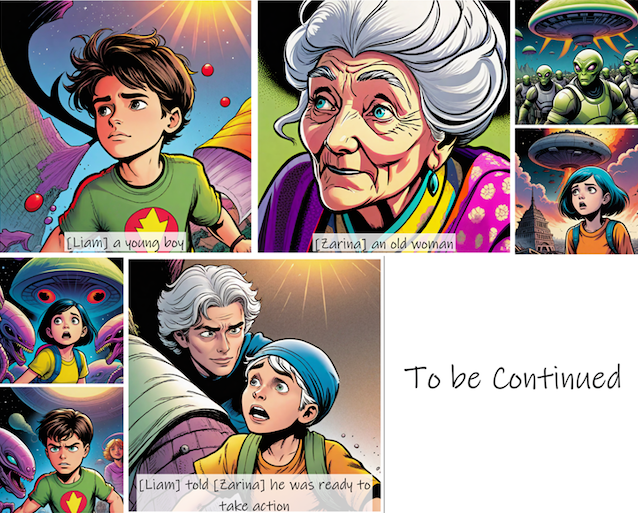


In [ ]:
comic_type = input()

### This step is time consuming while it generates image for each chapter at 2 mins per chapter, the total process will take 9~10 mins 

In [ ]:
images_list = []
image_fnames = []

start_index = 0
for i,p in enumerate(storyd_prompts[start_index:]):
    print(f"Chapter:{i} \nprompts:{p['prompt_array']}")  
    images = stod_image_generator.generate_images(general_prompt = p['general_prompt'],
                                                    style=sytle,
                                                    comic_type = comic_type,
                                                    prompt_array='\n'.join(p['prompt_array']),
                                                    id_length= p['id_length'],
                                                     sd_type = "Unstable",
                                                    ref_imgs=p['ref_imgs'],height=768,width=768)
    images_list.append(images)
    images_chapter = []
    for img in images:
        if img.size[0] > 1024:
            display(img)
            images_chapter.append(save_image(img))
    image_fnames.append(images_chapter)
            

- See saved image files

## 4.6 use story diffusion model to refine the style of character images
- In previous step 4.2, you've generated identity images for each character in a real vision sytle for character references (the references only accept real vision sytle images), however the book style is not the real vision style, so we need to use story diffusion model to refine the style of character images.

- define function to refine character images

In [ ]:
def refine_character_images(characters):
    character_names = [characters.main_character.name]
    name_figure_map = {characters.main_character.name:characters.main_character.figure}
    # add supporting characters
    for ch in characters.supporting_character:
        character_names += [ch.name]
        name_figure_map[ch.name] = ch.figure
    character_images = []
    
    for p,name in zip(sd_prompts,character_names):
        prompt_array = f"[{name}] {p.prompt}"
        general_prompt = f"[{name}] "+name_figure_map[name]+ ' img'
        print(f"general_prompt:{general_prompt}\nprompt_array:{prompt_array}")
        ref_imgs = [img_dicts[name]]
        images = stod_image_generator.generate_images(general_prompt = general_prompt,
                                                        style=sytle,
                                                        comic_type = "Four Pannel",
                                                        prompt_array=prompt_array,
                                                        id_length=1,
                                                        sd_type = "Unstable",
                                                        ref_imgs=ref_imgs,
                                                        height=768,
                                                        width=768)
        character_images.append(images)
    idenity_images = save_all_images_names([ img[-1] for img in character_images],[name+'_refined' for name in character_names])
    return idenity_images


- Refine images

In [ ]:
character_images = refine_character_images(characters)

In [ ]:
print(image_fnames)
print(character_images)

- Save the image file names in story object


In [ ]:
story.images = image_fnames
story.identity_images = character_images
with open('story_with_images.json','w') as f:
    f.write(story.json())

## 5. Save to docx file

In [ ]:
from story_agents.image_utils import save_as_docx

In [ ]:
save_as_docx(characters,story,f'{story.story_title}_original.docx')

### In the file browser Panel, open the story_with_images.json with text editor, then copy and paste to the answer box in the JAM Task.